<a href="https://colab.research.google.com/github/akankshabolla/Food-calorie-estimation/blob/main/Food_calorie_estimations_Using_Deep_Learning_And_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
MODEL_PATH = "/content/drive/MyDrive/project/custom-yolov4-detector_last(3500--98.61).weights"
CFG_FILE_PATH = "/content/drive/MyDrive/project/custom-yolov4-detector.cfg"
OBJ_FILE_PATH = "/content/drive/MyDrive/project/darknet_Yolov4_obj_names.names"
IMG_RESULT_PATH = "/content/drive/MyDrive/project/final_result_img"
TEST_IMG_FOLDER_PATH = "/content/drive/MyDrive/project/to_test"
WRITE_CROPPED_IMG_PATH = "/content/drive/MyDrive/project/cropped_img"

print("Model path exists:", os.path.isfile(MODEL_PATH))
print("Config file path exists:", os.path.isfile(CFG_FILE_PATH))
print("Classes file path exists:", os.path.isfile(OBJ_FILE_PATH))
print("Result image folder exists:", os.path.isdir(IMG_RESULT_PATH))
print("cropped image folder exists:", os.path.isdir(WRITE_CROPPED_IMG_PATH))

Model path exists: True
Config file path exists: True
Classes file path exists: True
Result image folder exists: True
cropped image folder exists: True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


\### PLEASE SET THE above 👆 ⬆️  PATHS AS PER YOUR NEEDS BEFORE MOVING AHEAD

### Some Constants

In [ ]:
# We know area of thumb. It is 5*2.3 cm².
# So area per pixel is actual thumb area divided by pixel thumb area of thumb.
SKIN_MULTIPLIER = 5 * 2.3

PIXEL_TO_CM_MULTIPLIER_CONSTANT = 5.0


# Load object classes


In [ ]:
classes = []
with open(OBJ_FILE_PATH, "r") as f:
    classes = [line.strip() for line in f.readlines()]

i = 0
for c in classes:
    print(f"{i}.-{c},", end=" ")
    i += 1

0.-Apple, 1.-Banana, 2.-Carrot, 3.-Onion, 4.-Orange, 5.-Qiwi, 6.-Tomato, 7.-thumb, 

# Load YOLO model

In [ ]:
net = cv2.dnn.readNet(MODEL_PATH, CFG_FILE_PATH)

# Get the names of the layers in the model
layer_names = net.getLayerNames()

# Get the output layers, accounting for different formats returned by getUnconnectedOutLayers
if isinstance(net.getUnconnectedOutLayers(), list):
    # If it returns a list of lists, use the first element in each
    outputlayers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
else:
    # If it returns a single array of indices, use the elements directly
    outputlayers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

# Generate random colors for each class
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# Optional: print the output layers and colors for debugging
print("Output Layers:", outputlayers)
print("Bounding Box Colors for Classes:", colors)


Output Layers: ['yolo_139', 'yolo_150', 'yolo_161']
Bounding Box Colors for Classes: [[241.51602644  66.1590414  132.22077293]
 [147.55661708 100.33101878  77.71755008]
 [118.45232524 132.39574815  17.09814065]
 [ 74.24928173 122.64768889 116.39890663]
 [ 27.82009871 201.32278897 178.82975979]
 [136.23212713  82.02918205 235.7781421 ]
 [ 46.28320769 102.52695925 185.19536417]
 [ 87.40293342  76.4420416  110.67106962]]


# helper functions for showing images

In [ ]:
def imShow(path):
    if type(path) == str():
        image = cv2.imread(path)
    else:
        image = path

    height, width = image.shape[:2]
    resized_image = cv2.resize(
        image, (3 * width, 3 * height), interpolation=cv2.INTER_CUBIC
    )

    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.show()

# Helper crop function

In [ ]:
def crop_img(input_img, img_name, bb_cordinate, img_save_path=None, pixel_margin=5):
    """Crop the given input image based on  bb_cordinate and pixel_margin
    and save the image to img_save_path if present

    Args:
        input_img (ImgArray): input image.
        img_save_path (str, optional): path to directory where you want to save this images.
        img_name (str): Image name.
        bb_cordinate (list): List of bounding box cordinates in this [xmin, ymin, w, h] format.
        pixel_margin (int, optional): Use this to add extra margins to add while cropping objects.
        This is based on BB coordinates. Defaults to 5.

    Returns:
    ```
    Dict: {
        "img_name": img_name,
        "cropped_image": croppend image array,
        "pixel_margin": pixel_margin,
        "input_img_shape": input_img.shape,
        "bb_cordinate": {"xmin": xmin, "ymin": ymin, "width": w, "height": h},
        "calculated_copped_cordinates": {
            "Y_MIN": Y_MIN,
            "Y_MAX": Y_MAX,
            "X_MIN": X_MIN,
            "X_MAX": X_MAX,
        },
    }
    ```
    """
    # use this to determine the boundary condition, to know based on given margin can we add the margin or not.
    # if given margin exceed the range we will take the given xmin and ymin form bb_cordinate
    dh, dw, cha = input_img.shape

    # if any bb cor-number is less than zero make it positive
    for i in range(len(bb_cordinate)):
        if bb_cordinate[i] < 0:
            bb_cordinate[i] = abs(bb_cordinate[i])
    # here any -ve bounding will be considered as +ve , e.g -5 will be taken as +5

    xmin, ymin, w, h = bb_cordinate  # e.g [372, 33, 170, 295] # reactangle data

    # how many pixel you want to add while cropping an image
    p = pixel_margin
    # to add 5 more pixels at the left side
    if xmin - p >= 1:  # xmin
        X_MIN = xmin - p
    else:
        X_MIN = xmin

    # to add 5 more pixels at the Above (☝️ top +Y direction) side
    if ymin - p >= 1:  # ymin
        Y_MIN = ymin - p
    else:
        Y_MIN = ymin

    if (ymin + h) + p > dh:  # Y max
        Y_MAX = ymin + h
    else:  # to add 5 more pixels at the bottom side
        Y_MAX = (ymin + h) + p

    if (xmin + w) + p > dw:  # x max
        X_MAX = xmin + w
    else:  # to add 5 more pixels at the right side
        X_MAX = (xmin + w) + p

    # print()       above+5    bottom+5    left+5    right+5
    # imgCrop = img1[ ymin:   ymin + h  ,  xmin:    xmin+ w  ]
    # slice it.
    imgCrop = input_img[Y_MIN:Y_MAX, X_MIN:X_MAX]

    # store the every cropped img data into dictionary
    cropped_img_dict = {}
    cropped_img_dict[img_name] = imgCrop

    # print(imgCrop)
    if img_save_path:
        # cv2.imwrite( img_save_path, imgCrop)
        cv2.imwrite(os.path.join(img_save_path, img_name), imgCrop)

    # return cropped_img_dict , bb_cordinate
    return {
        "img_name": img_name,
        "cropped_image": imgCrop,
        "pixel_margin": pixel_margin,
        "input_img_shape": input_img.shape,
        "bb_cordinate": {"xmin": xmin, "ymin": ymin, "width": w, "height": h},
        "calculated_copped_cordinates": {
            "Y_MIN": Y_MIN,
            "Y_MAX": Y_MAX,
            "X_MIN": X_MIN,
            "X_MAX": X_MAX,
        },
    }

# funtion 2 for detection objects

In [ ]:
def detect_objects_from_image(
    input_array_img, baseline_confidence=0.5, input_img_size=(608, 608)
):
    """Detect the objects present in the image.
    it will return the objects which have confidence score of more than

    Args:
        input_array_img (ImgArray): Inputted image array
        baseline_confidence (float, optional): baseline to select dections above it. Defaults to 0.5.
        input_img_size (tuple, optional): imgage size to create img blob. Defaults to (608,608).

    Returns:
    ```
        Dict: {
            "class_ids": class ids for its slected dectections,
            "confidences": confidences of corresponding to class ids for its slected dectections,
            "boxes": bounding box coordinates of corresponding to class ids for its slected dectections,
        }
    ```
    """

    start_time = time.time()
    count = 0
    # # Example
    # blob = cv2.dnn.blobFromImage(input_array_img, scalefactor=0.00392, size=(416,416), mean(Scalar)=(0,0,0), swapRB=True, crop=False)
    blob = cv2.dnn.blobFromImage(
        input_array_img, 0.00392, input_img_size, (0, 0, 0), True, crop=False
    )

    net.setInput(blob)
    outs = net.forward(outputlayers)

    # Showing info on screen/ get confidence score of algorithm in detecting an object in blob
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > baseline_confidence:
                # object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # rectangle co-ordinaters
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                # # Draw BB(Bounding Boxes) on images based on detected object coordinates
                # # we wont be drawing the BB now as we need this detect objects (area) later in segmentation
                # cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
                # # draw circle on detected objects
                # cv2.circle(img,(center_x,center_y),10,(0,255,0),2)

                boxes.append([x, y, w, h])  # collect all rectangle areas
                confidences.append(float(confidence))  # confidence detected object
                class_ids.append(class_id)  # index of the object tha was detected
                # bounding_box_dict['class_ids_'+str(count)] = [center_x,center_y,w,h]
                count += 1
    # end time
    end_time = time.time()
    print(
        f"all objects Bounding Boxes,Confidences,class id's are found in : {end_time - start_time} Seconds"
    )
    return {
        "class_ids": class_ids,
        "confidences": confidences,
        "boxes": boxes
    }

## segmentation funtion :

#### Food segmentation
In this process we use calibration object for find real area of foods. In this process we used thumb is a calibration object.

Using python OpenCV library, we first contour of food and thumb then calculate contour area of food and thumb

We know area of thumb. It is 5*2.3 cm². So area per pixel is actual thumb area divided by pixel thumb area of thumb.

From this actual food area is pixel area of food * area per pixel.

We assume some shape of foods i.e apple like sphere and banana like cylinder

In [ ]:
import matplotlib.image as mpimg


def image_segmentation(cropped_img_name, cropped_img):
    """Perform steps for segmentation of objects from an image
    based on fruit classes it handles the different age cases to find out the right contour area
    which will be later used to find the volume and its calories.

    Args:
        cropped_img_name (str): Image name
        cropped_img (NpImgArray): cropped images

    Returns:
    ```
    Dict: {
        "segmented_obj_contour_area_pixel": [
            req_contour, # This is coutour area of segmented object
            req_object_area, # The area represents the number of pixels enclosed within the contour,
                             # which gives a measure of the size of the object in the image
            pix_to_cm_multiplier # (optional) used for real-world dimensional analysis and only available if class is of thumb
        ],
        "segmented_images_data": [
            cv2_img, # original image, serves as the baseline reference for the segmented objects.
            mask_fruit, # It highlights the segmented object against a black background
            img_contour, # This is the image mask with the largest contour drawn on it.
            img_contour4, # This image mask has the required contour (the largest or second largest, depending on the object) drawn on it.
            Thumb_img_min_rectangle # (optional) This is an image with a minimum enclosing rectangle drawn around the thumb contour.
                                    # It is used to calculate the pixel-to-centimeter conversion factor and is included only when processing a thumb image.
        ],
    }
    ```
    """

    # Start time to measure the duration of the segmentation process
    start_time = time.time()

    # Convert the input image to a format suitable for OpenCV processing
    # OpenCV uses BGR format by default, so we ensure the image is in the correct format.
    cv2_img = cropped_img  # cropped_img[ : , : , ::-1 ]  # Reverse the channels if needed

    # Convert the image to grayscale for thresholding
    # Grayscale conversion simplifies the image, reducing it to a single channel.
    # This is necessary for thresholding and contour detection, as it enhances contrast between the object and the background.
    # cv2_img_gray=cv2.imread(cropped_img,0)
    cv2_img_gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to create a binary image
    # Adaptive thresholding allows for local variations in illumination.
    # This method is particularly useful for images with varying lighting conditions across different regions.
    # The result is a binary image where pixels are either 0 (black) or 255 (white), which is ideal for contour detection.
    adap_thresh = cv2.adaptiveThreshold(
        cv2_img_gray, 100, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2
    )

    # Find contours in the binary image
    # Contours are the boundaries of objects in the image.
    # Detecting contours helps in identifying and isolating objects within the image.
    contours, hierarchy = cv2.findContours(
        adap_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )

    # Sort contours by area to find the largest one
    # Sorting by area helps in identifying the most significant object in the image.
    # Often, the largest contour corresponds to the main object of interest.
    largest_areas = sorted(contours, key=cv2.contourArea)

    # Create a mask for the largest contour
    # A mask is a binary image that isolates the object of interest.
    # This mask will be used to extract the main object from the original image.
    mask = np.zeros(cv2_img_gray.shape, np.uint8)
    img_contour = cv2.drawContours(
        mask, [largest_areas[-1]], 0, (255, 255, 255, 255), -1
    )

    # Load the original image again (or use the passed image directly)
    # This step ensures we have the original image to work with after applying the mask.
    plt_img = cropped_img

    # Apply the mask to the original image to isolate the segmented object
    # By applying the mask, we keep the region of interest (the object) and discard the background.
    img_bitcontour = cv2.bitwise_or(plt_img, plt_img, mask=mask)

    # Convert the masked image to HSV color space for further segmentation
    # HSV (Hue, Saturation, Value) color space is often more effective for color-based segmentation than RGB or BGR.
    # It allows us to isolate colors more precisely, which is useful for distinguishing objects based on color.
    hsv_img = cv2.cvtColor(img_bitcontour, cv2.COLOR_BGR2HSV)

    # Create a mask to filter out certain colors (plate colors in this case)
    # We filter out a specific color range (e.g., plate colors) to focus on the object of interest.
    # This is useful in cases where the background or other elements have distinct colors that we want to exclude.
    mask_plate = cv2.inRange(hsv_img, np.array([0, 0, 50]), np.array([200, 90, 250]))

    # Invert the plate mask to focus on the object of interest
    # Inverting the mask means we now focus on everything except the plate colors.
    # This step helps in isolating the object by removing any distracting background elements.
    mask_not_plate = cv2.bitwise_not(mask_plate)

    # Final segmented image of the object, with the plate masked out
    # The final segmented image highlights the object of interest with the background effectively removed.
    mask_fruit = cv2.bitwise_and(img_bitcontour, img_bitcontour, mask=mask_not_plate)

    # Optional: Titles and images can be displayed (commented out in this code)
    # Uncomment these lines if visualization of the segmentation process is needed.
    # titles = ["original", 'Output', "masked of final fruit"]
    # images = [cv2_img, mask_fruit_finger, mask_not_plate]

    # Process further to get the contour of the segmented object
    # This step is important for identifying the exact shape and boundary of the segmented object.
    rgb_img = mask_fruit.copy()
    img_gray2 = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding again for the new grayscale image
    # This second thresholding step refines the segmentation, particularly if the object has complex internal structure.
    adap_thresh2 = cv2.adaptiveThreshold(
        img_gray2, 100, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 2
    )

    # Find contours again in the thresholded image
    # Detecting contours again helps in refining the segmentation to focus more closely on the object.
    cont2, _ = cv2.findContours(adap_thresh2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area to find the largest ones
    # Sorting by area allows us to select the most relevant contour, usually the largest one.
    # In some cases, the second-largest contour might be relevant, especially if the object has sub-parts (like the thumb or carrot).
    largest_areas2 = sorted(cont2, key=cv2.contourArea)
    print(f"Total number of contours: {len(largest_areas2)} for {cropped_img_name}")

    # Prepare a mask to draw contours on
    # Creating a copy of the mask allows for drawing without modifying the original mask.
    mask2 = np.zeros(img_gray2.shape, np.uint8)
    cop = mask2.copy()

    # Label list for different objects, including the thumb and various fruits
    # The label list helps in identifying the object type, which guides how we handle the contour.
    #  indexs       0         1         2         3        4        5         6         7
    label_list = ["thumb", "Apple", "Banana", "Orange", "Qiwi", "Tomato", "Carrot", "Onion" ]
    # Contour     -1or-2      -1        -1       -1        -1       -1        -2      -1or-2
    # Areas that I find out while doing experiments , that it might happend that 2nd largest countour is relevent in our case
    # -1 means largest countour and -2 means 2nd largest countour

    Thumb_img_min_rectangle = None

    # Handle the specific case for the thumb
    if cropped_img_name.startswith(label_list[0]):  # Thumb
        # For the thumb, we usually care about the largest contour.
        # We extract this contour and calculate its area.
        req_contour = largest_areas2[-1]
        img_contour4 = cv2.drawContours(cop, [req_contour], 0, (255, 255, 255, 255), -1)
        req_object_area = cv2.contourArea(req_contour)

        # Compute the minimum area rectangle around the contour
        # The minimum area rectangle is useful for calculating the height and width of the object.
        rect = cv2.minAreaRect(req_contour)
        box = cv2.boxPoints(rect)
        box2 = np.int0(box)

        # Calculate the pixel-to-centimeter conversion multiplier based on thumb height
        # This conversion is crucial for applications requiring real-world measurements.
        pix_height = max(rect[1])
        # pix_to_cm_multiplier is a conversion factor that translates the height of an object in pixels to its real-world height in centimeters.
        pix_to_cm_multiplier = PIXEL_TO_CM_MULTIPLIER_CONSTANT / pix_height # thumb height

        # Draw the minimum area rectangle on the original image
        # This visualization step is useful for verifying the accuracy of the rectangle calculation.
        copy_original = cv2_img.copy()
        Thumb_img_min_rectangle = cv2.drawContours(
            copy_original, [box2], 0, (0, 255, 0), 2
        )

        print(
            "For Thumb class we have below information"
            f"\nRectangle: {rect} \nBox points: {box} \nPixel height: {pix_height} \n"
            f"Pixel to cm multiplier: {pix_to_cm_multiplier}"
        )

        # Return the contour, area, and pixel-to-cm multiplier for the thumb
        # These metrics are crucial for applications where the thumb size and position matter.
        result = [req_contour, req_object_area, pix_to_cm_multiplier]

    # Handle the specific case for the carrot
    elif cropped_img_name.startswith(label_list[6]):  # Carrot
        # For the carrot, the relevant contour might not be the largest but the second largest.
        # Carrots are elongated, so the largest area might correspond to a different part of the image.
        req_contour = largest_areas2[-2]
        img_contour4 = cv2.drawContours(cop, [req_contour], 0, (255, 255, 255, 255), -1)
        req_object_area = cv2.contourArea(req_contour)
        result = [req_contour, req_object_area]

    # Handle the case for all other objects
    else:  # Other objects
        # For other objects, the largest contour is typically the most relevant one.
        req_contour = largest_areas2[-1]
        img_contour4 = cv2.drawContours(cop, [req_contour], 0, (255, 255, 255, 255), -1)
        req_object_area = cv2.contourArea(req_contour)
        result = [req_contour, req_object_area]

    print(
        f"\nThe largest object contour area: {req_object_area} for {cropped_img_name}"
    )

    # End time to measure the duration of the segmentation process
    end_time = time.time()
    print(f"Segmentation of an object done in: {end_time - start_time} seconds")

    # Final output: return contour, area, and pixel-to-cm multiplier, along with image data
    # The image data list contains various stages of the image processing, useful for debugging and visualization.
    img_data_list = [cv2_img, mask_fruit, img_contour, img_contour4]
    if Thumb_img_min_rectangle is not None:
        img_data_list.append(Thumb_img_min_rectangle)

    return {
        "segmented_obj_contour_area_pixel": result,
        "segmented_images_data": img_data_list,
    }

## calories :

In [ ]:
# 1.-Apple, 2.-Banana, 3.-Carrot, 4.-Onion, 5.-Orange, 6.-Qiwi, 7.-Tomato, 8.-thumb,

# "thumb""0.641
# density - gram / cm^3
density_dict = {
    "Apple": 0.96,
    "Banana": 0.94,
    "Carrot": 0.641,
    "Onion": 0.513,
    "Orange": 0.482,
    "Tomato": 0.481,
    "Qiwi": 0.575,
}
# kcal
calorie_dict = {
    "Apple": 52,
    "Banana": 89,
    "Carrot": 41,
    "Onion": 40,
    "Orange": 47,
    "Tomato": 18,
    "Qiwi": 44,
}

#                0        1        2          3        4        5         6         7
label_list = ["thumb", "Apple", "Banana", "Orange", "Qiwi", "Tomato", "Carrot", "Onion"]
#            -1or-2     -1         -1         -1       -1       -1        -2      -1or-2


def getCalorie(label, volume):  # # volume in cm^3
    calorie = calorie_dict[label]
    density = density_dict[label]
    mass = volume * density * 1.0
    calorie_tot = (calorie / 100.0) * mass
    return mass, calorie_tot, calorie  # # calorie per 100 grams


#                    fruitA   thumbA            PC                FC
def getVolume(label, area, skin_area, pix_to_cm_multiplier, fruit_contour):
    # From this actual food area is pixel area of food * area per pixel.
    # We assume some shape of foods i.e apple like sphere and banana like cylinder

    area_fruit = (area / skin_area) * SKIN_MULTIPLIER  # area in cm^2
    # lebel = string = label_list[i]
    # #label = int(label)
    volume = 100
    #              1                        5                      7                          6
    if (
        label == label_list[1]
        or label == label_list[3]
        or label == label_list[4]
        or label == label_list[5]
        or label == label_list[7]
    ):
        # # sphere-apple,orange,kiwi,tomato,onion
        radius = np.sqrt(area_fruit / np.pi)
        volume = (4 / 3) * np.pi * radius * radius * radius
        # print (area_fruit, radius, volume, skin_area)

    #      2             4                3
    if label == label_list[2] or label == label_list[6] and area_fruit > 30:
        # # cylinder like banana, cucumber, carrot
        fruit_rect = cv2.minAreaRect(fruit_contour)
        height = max(fruit_rect[1]) * pix_to_cm_multiplier
        radius = area_fruit / (2.0 * height)
        volume = np.pi * radius * radius * height

    if label == 4 and area_fruit < 30:  # carrot
        volume = area_fruit * 0.5  # assuming width = 0.5 cm

    return volume


def calories(segmentation_to_calorie):
    """
    Calculate the calorie content of various fruits based on image segmentation.

    Args:
        segmentation_to_calorie (dict): A dictionary where:
            - Keys are the object name, confidence, bounding box number, and image file name (e.g., 'Carrot(95.66)_10.jpg').
            - Values are lists containing:
                - [thumb/fruit contour, thumb/fruit contour area, pixel-to-centimeter multiplier]
                - Image coordinates.

    Returns:
        dict: A dictionary with:
            - Keys as processed names of objects along with their calorie information.
            - Values as lists containing the formatted name and image coordinates.
            ```
            {
                "thumb / fruit" : [ objectName , [bounding box] ] ,
                "apple"         : [ apple(89.34)_45Kcal_5 , [372, 33, 170, 295] ],
                ...
            }
            ```
    """

    # Start timing the calorie calculation process
    start_time = time.time()

    # Dictionary to store the calculated calories for each fruit
    fruit_calories_dict = {}

    # Variables to store contour area and pixel-to-cm multiplier for the reference object (thumb)
    skin_contour_Area = pix_cm = None

    # Iterate over all entries in the segmentation_to_calorie dictionary
    for k in segmentation_to_calorie:
        if k.startswith("thumb"):
            # Extract the thumb's contour, area, and pixel-to-cm multiplier
            skin_contour = segmentation_to_calorie[k][0][0]
            skin_contour_Area = segmentation_to_calorie[k][0][1]
            pix_cm = segmentation_to_calorie[k][0][2]

            # Get the image coordinates for the thumb
            img_cordinates = segmentation_to_calorie[k][1]

            # Add thumb details to the fruit_calories_dict for further use
            fruit_calories_dict[k] = [k.split("_")[0], img_cordinates]

    # Check if the reference object (thumb) was found, if not, print a warning
    if skin_contour_Area is None and pix_cm is None:
        print("++++++++++++|||-------------*************** IMPORTANT NOTICE ***************-------------|||++++++++++++\n")
        print("------!Reference Object (thumb) not found in the image. Please provide one to proceed with calorie estimation!------\n")
        print("++++++++++++|||-------------*************** IMPORTANT NOTICE ***************-------------|||++++++++++++\n")

    # Iterate over the objects in the image to calculate calories
    for k in segmentation_to_calorie:
        if not k.startswith("thumb"):
            # Extract the fruit's contour and area
            fruit_contour = segmentation_to_calorie[k][0][0]
            # # req_contour, This is coutour area of segmented object
            fruit_contour_Area = segmentation_to_calorie[k][0][1]
            # # req_object_area, The area represents the number of pixels enclosed within the contour

            # # Extract object name, confidence, and bounding box number
            # # objName(confidence)_bbNum.jpg  e.g: 'Carrot(95.66)_10.jpg'
            name = k.split("_")[0].split("(")[0]  # Object name
            objName_Confidence = k.split("_")[0]
            bbNum = k.split("_")[1][:-4]  # Bounding box number
            img_cordinates = segmentation_to_calorie[k][1]

            # Calculate volume, mass, and calories if reference object data is available
            if skin_contour_Area is not None and pix_cm is not None:
                volume = getVolume(
                    name, fruit_contour_Area, skin_contour_Area, pix_cm, fruit_contour
                )
                mass, cal, cal_100 = getCalorie(name, volume)
                fruit_volumes = volume
                fruit_calories_100grams = cal_100
                fruit_mass = mass
                fruit_calories = cal
                print(
                    f"\nfruit_volumes {fruit_volumes},\nfruit_calories {fruit_calories},fruit_calories_100grams {fruit_calories_100grams}, \nfruit_mass {fruit_mass}"
                )

                # Format the results for output
                final_result_name = (
                    f"{objName_Confidence}_{round(fruit_calories)}kcal_{bbNum}"
                )

                # Print the results of the calorie estimation for each object
                print(final_result_name, img_cordinates)
                print(
                    f"Calorie estimation completed for {name}. Estimated calories: {round(fruit_calories, 3)} kcal/g\n"
                )
            else:
                # If no reference object, just store the object name and bounding box number
                # as without reference object we wont be able to calculate the calories
                final_result_name = f"{objName_Confidence}_{bbNum}"

            # Store the calculated results in the fruit_calories_dict
            fruit_calories_dict[k] = [final_result_name, img_cordinates]

    # End timing the calorie calculation process
    end_time = time.time()
    print(f"All object calories calculated in: {end_time - start_time} seconds")

    return fruit_calories_dict

## Get required detections
#### Performs below steps
- Crop the image
- Do the segmentation
- Find the calories of fruits

In [ ]:
def find_required_detections(
    input_image, class_ids, confidences, boxes, font=cv2.FONT_HERSHEY_PLAIN
):
    """Find the required detections

    Args:
        input_image (NpImgArray): Input image
        class_ids (list): class ids for its slected dectections.
        confidences (list): confidences of corresponding to class ids for its slected dectections.
        boxes (list): bounding box coordinates of corresponding to class ids for its slected dectections.
        font (cv2_font, optional): Custom font style for writing details on image. Defaults to cv2.FONT_HERSHEY_PLAIN.

    Returns:
        ```
        Dict: {
            "id": count, # some id
            "result_img": result_img, # ImgArray
            "step_information": step_information, # for each detected object intermediate steps information
            "segmentation_to_calorie": segmentation_to_calorie, # values to Calculate calories
            "final_calories_data": final_data, # values after we calculated calorie

        }
        ```
    """

    global drawn
    global required_bb_detections, step_information
    required_bb_detections = {}
    step_information = {}
    count = 1

    # start time
    start_time = time.time()

    # cv2.dnn.NMSBoxes(boxes,confidences,score_threshold,IOU_threshold)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.4, 0.6)  # Non Max Suppressions

    print(f"the required BB's indexes are: \n", indexes)

    # Now using below loop over all boxes
    # if box is appearing in indexes then only draw detections for it
    # put text of class name on it.
    # font = cv2.FONT_HERSHEY_PLAIN

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])

            img_name = f"{label}({round(confidences[i]*100 ,2)})_{i}.jpg"
            print(f"\nthe the respective lables are--> BB_No.{i} = {label}")

            # gather the name of obj and its coordinatesonly which are required in below format
            # { "<class_label> + (<confidence_score)>) + _ + <index>" : [x, y, w, h ]}
            required_bb_detections[img_name] = boxes[i]

    # end time
    end_time = time.time()
    print(f"all required object are found in : {end_time - start_time} Seconds")

    # -----------------------*****************************--------------------------

    segmentation_to_calorie = {}
    # for every img call required function calls for processing
    print(
        "\n***********------ images processing intermediate steps started ------***********\n"
    )
    # start time
    start_time = time.time()
    for req_detected_img_name in required_bb_detections:

        ### ******* crop img funcion call
        cropped_img_data = crop_img(
            input_image,
            req_detected_img_name,
            required_bb_detections[req_detected_img_name],
            img_save_path=WRITE_CROPPED_IMG_PATH
        )
        cropped_img_name = cropped_img_data["img_name"]  # same as req_detected_img_name
        cropped_img = cropped_img_data["cropped_image"]
        print(f"\ncropping done for--> {cropped_img_name}")

        ### ******* Segmentation of img *******
        image_segmentation_response = image_segmentation(
            cropped_img_name, cropped_img
        )
        segmented_obj_contour_area_pixel = image_segmentation_response["segmented_obj_contour_area_pixel"]
        segmented_images_data = image_segmentation_response["segmented_images_data"]
        # if thumb then : len > 2  and list[0] = contour  of food or thumb ;list[1]=Contour Area ;list[2] = pixel to centimeter
        # image cordinates
        segmentation_to_calorie[cropped_img_name] = [
            segmented_obj_contour_area_pixel,
            required_bb_detections[req_detected_img_name],
        ]

        print(
            f"Segmentaion done for--> {cropped_img_name} and Area is {segmented_obj_contour_area_pixel[1]}"
        )
        step_information[req_detected_img_name] = {
            "req_detected_img_name": req_detected_img_name,
            "cropped_img_data": cropped_img_data,
            "segmented_img_data": segmented_images_data,
        }

    print(
        "\n------------------*Steps done moving ahead with calories*------------------\n"
    )

    ## Calories funtion call --> collect all the calories of required objects
    final_data = calories(segmentation_to_calorie)
    print("Hello this is final calories",final_data)
    # end time
    end_time = time.time()
    print(f"image processing part 2 completed in : {end_time - start_time} Seconds")

    # --------------------------*****************************--------------------------

    print("\n***********------ images Display part started ------***********\n")
    start_time = time.time()
    print(final_data, f"\nlength of dictionary is: {len(final_data)}")

    result_img = input_image.copy()
    print("\n copy img before detection is---:\n")
    imShow(result_img)

    for k in final_data:
        ## key = objName(confidence)Calories_bbNum.jpg
        ## value = [ img name+confidence+calories+bbNum , bounding box cordinates ]
        ## example :
        doc_string = """
          dictionary = { "thumb / fruit" : [ objectName , [bounding box coordinates] ] ,
                         "apple"         : [ apple(89.34)_45Kcal_5 , [372, 33, 170, 295] ],
                          ....
                        }
        """

        final_img_name, BB_Cordinates = final_data[k][0], final_data[k][1]
        x, y, w, h = BB_Cordinates

        # you can you any color you want here for drawing bounding boxes for detected objects
        color = colors[2] if len(colors) > 2 else colors[i // 2]

        # # Draw BB(Bounding Boxes) on images based on detected object coordinates
        cv2.rectangle(result_img, (x, y), (x + w, y + h), color, 2)
        # # Add the class name on the BB
        cv2.putText(
            result_img, final_img_name, (x, y + 30), font, 1, (255, 255, 255), 2
        )
        print(f"Drawn part done for--> {final_img_name} ")

    end_time = time.time()
    print(f"display part done in {end_time - start_time} Seconds")
    print("\n copy img After detection is---:\n")
    imShow(result_img)

    print("\n***********------ images Display part ended ------***********\n")

    response = {
        "id": count,
        "result_img": result_img,
        "step_information": step_information,
        "segmentation_to_calorie": segmentation_to_calorie,
        "final_calories_data": final_data,
    }
    count += 1

    return response

# collect all the data for later use - History

In [ ]:
history_final_result_img = []


def show_history(history_list, min_show_limit=5):

    order, show_limit = map(
        int,
        input(
            """
    enter '1' for seeing in recent order else enter 0 to see from very start
    and limit for displaying the total number of images
    """
        ).split(),
    )

    if show_limit < 1 and show_limit > len(history_list):
        print(
            f"Invalid limit, Next time plz provide value greater than 1 and less than {len(history_list)}"
        )
        print(f"for now we are moving ahead with {min_show_limit}")
        show_limit = min_show_limit
    history_list = history_list[:show_limit]

    if order == 1:
        for i in range(len(history_list) - 1, -1, -1):
            imShow(history_list[i])
    elif order == 0:
        for i in range(len(history_list)):
            imShow(history_list[i])

# main funtion starts here !

hi please check the below list of images and select the one you like...
0  -  carrots3_hori.jpg
1  -  onion2.jpg
2  -  Appls11.jpg
3  -  carrots1_verti.jpg
4  -  onion4.jpg
5  -  onion1.jpg
6  -  onion3.jpg
7  -  Appls3.jpg
8  -  carrots5 and apple.jpg
9  -  Appls21.jpg
10  -  carrots6 and apple.jpg
11  -  carrots2 and apple.jpg
12  -  Appls1_verti.jpg
13  -  Appls2_verti.jpg
14  -  Appls4.jpg
15  -  download.jpg
16  -  carrots1_hori.jpg
17  -  carrots4.jpg
18  -  carrots3_verti.jpg
19  -  carrots7.jpg
enter the no. of image u want to test : 0 to 18--> 3
enter the numeric choice(1,2,3) for scalling
        custom 1 : 608 x 608
        custom 2 : fx=0.4 , fy=0.3
        custom 3 : original3
Image Dimensions details height: 1152, width: 560, channels: 3
all objects Bounding Boxes,Confidences,class id's are found in : 2.440781831741333 Seconds
--------------------------------------------------------
No.:0-> 2 : Carrot -> 97.05%
No.:1-> 2 : Carrot -> 97.53%
No.:2-> 2 : Carrot -> 87.12%
No.

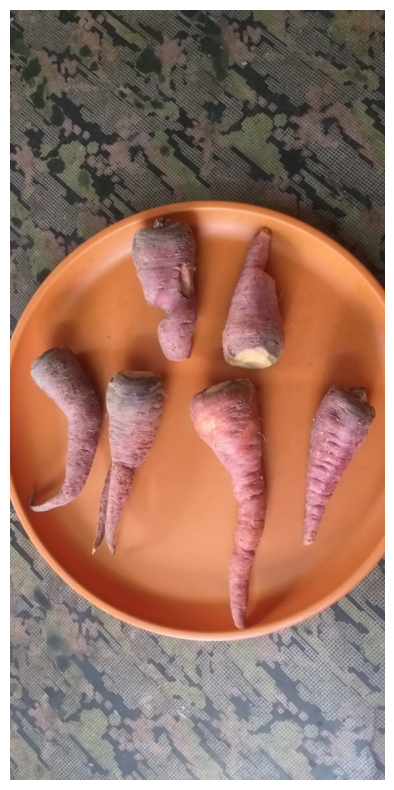

Drawn part done for--> Carrot(97.53)_1 
Drawn part done for--> Carrot(98.77)_10 
Drawn part done for--> Carrot(99.3)_14 
Drawn part done for--> Carrot(99.33)_17 
Drawn part done for--> Carrot(99.02)_20 
Drawn part done for--> Carrot(99.07)_21 
display part done in 0.684319257736206 Seconds

 copy img After detection is---:



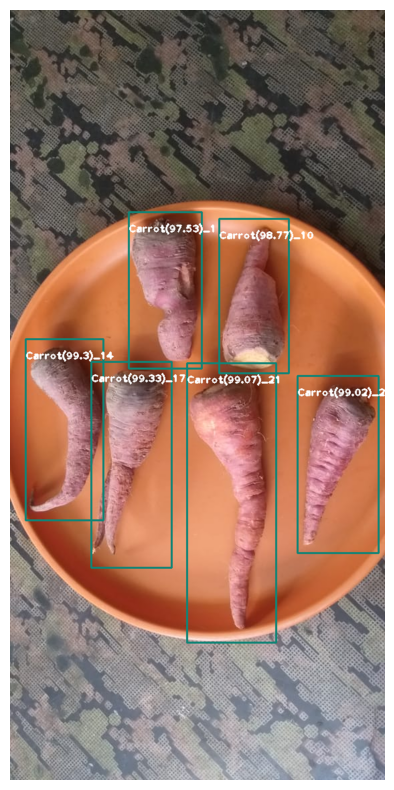


***********------ images Display part ended ------***********



KeyboardInterrupt: Interrupted by user

In [ ]:
### loading image
print("hi please check the below list of images and select the one you like...")

images_list = []
for count, filename in enumerate(os.listdir(TEST_IMG_FOLDER_PATH)):
    images_list.append(filename)
    print(count, " - ", images_list[count])


# ********************************************************************

ask_img = int(input(f"enter the no. of image u want to test : 0 to {count-1}--> "))
final_img = images_list[ask_img]

img1 = cv2.imread(r"{}".format(os.path.join(TEST_IMG_FOLDER_PATH, final_img)))

choice = int(
    input("""
        enter the numeric choice(1,2,3) for scalling
        custom 1 : 608 x 608
        custom 2 : fx=0.4 , fy=0.3
        custom 3 : original
    """.strip()
    )
)

if choice == 1:
    img1 = cv2.resize(img1, (608, 608))
elif choice == 2:
    img1 = cv2.resize(img1, None, fx=0.4, fy=0.3)
else:
    img1 = img1

height, width, channels = img1.shape
print(
    f"Image Dimensions details height: {height}, width: {width}, channels: {channels}"
)

# --------------------------------------------------------------
detected_img_objects_data = detect_objects_from_image(img1)
class_ids, confidences, boxes = detected_img_objects_data.values()
print("--------------------------------------------------------")

if class_ids == []:
    print("Can't detect objects inside image!")
else:
    for i in range(len(class_ids)):
        print(
            f"No.:{i}-> {class_ids[i]} : {classes[class_ids[i]]} -> {round(confidences[i]*100 ,2)}%"
        )

print("-------------------------*Object Detection Phase Done*-------------------------")

# Get the required objects
response = find_required_detections(img1, class_ids, confidences, boxes)
result_img = response["result_img"]
if choice >= 3:
    drawn = cv2.imwrite(
        os.path.join(IMG_RESULT_PATH, "result_Original_" + images_list[ask_img]),
        result_img,
    )
else:
    drawn = cv2.imwrite(
        os.path.join(IMG_RESULT_PATH, "result_" + images_list[ask_img]), result_img
    )

# print("\nthe result image is ")
# imShow(result_img)

history = input(
    "\n\nWould you like to check the privious History of Images, provided you have used the system  more than once...(¬‿¬)\n ==> yes or Y / no or N \n"
)
history_final_result_img.append(result_img)
if history == "yes" or history == "Y":
    print(
        f"\n****** currently we have {len(history_final_result_img)} images in our database....******"
    )
    # print(history_final_result_img)
    show_history(history_final_result_img)